# Import Libraries and Packages

In [2]:
from __future__ import division

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

sns.set_style("whitegrid")
sns.set_palette("colorblind")

%matplotlib inline

# Import & Prepare Data

In [3]:
df = pd.read_csv('../data/demand-forecasting-kernels-only/train.csv')

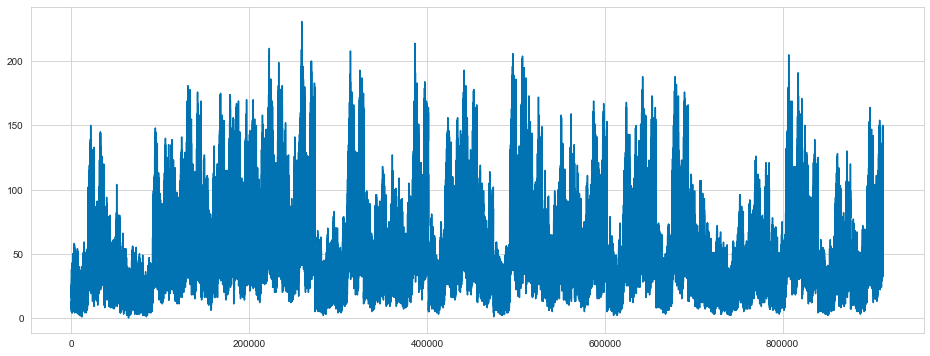

In [4]:
df['sales'].plot(figsize=(16,6))

In [5]:
df['store'].value_counts()

10    91300
9     91300
8     91300
7     91300
6     91300
5     91300
4     91300
3     91300
2     91300
1     91300
Name: store, dtype: int64

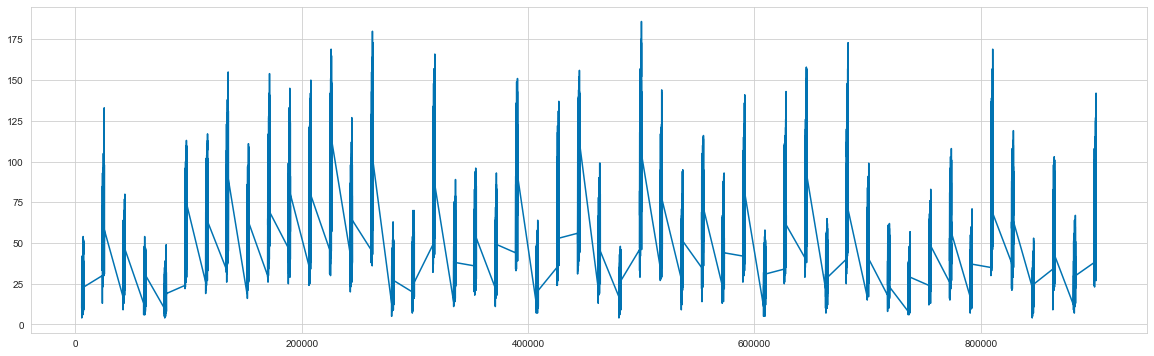

In [6]:
df[df['store']==4]['sales'].plot(figsize=(20,6))

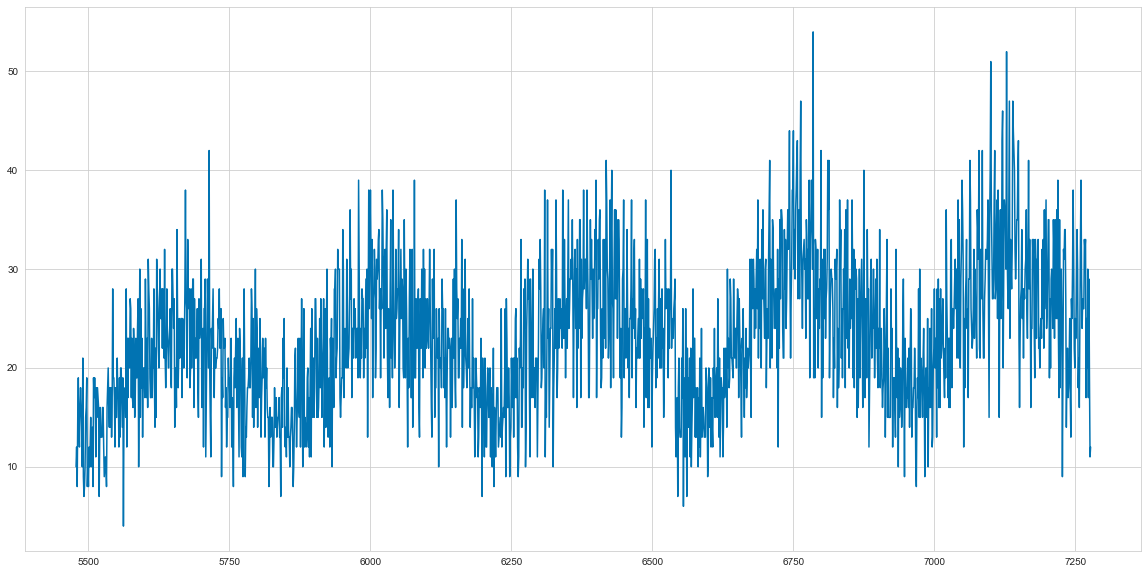

In [7]:
df[df['store']==4][0:1800]['sales'].plot(figsize=(20,10))

In [9]:
data = df[df['store']==4][0:1750]


In [10]:
data.reset_index(inplace=True)


In [11]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Sales")
    plt.grid(True)

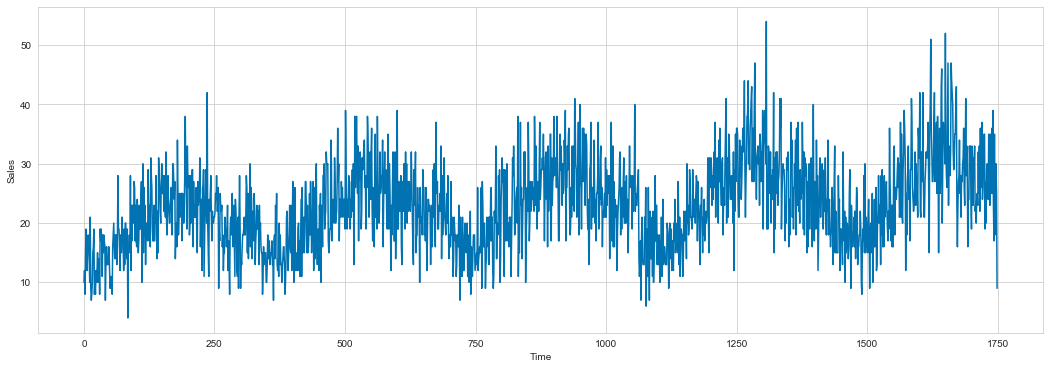

In [12]:
# Prepare sequence data

time = np.array(data.index.to_list())
series = np.array(data.sales.to_list())

plt.figure(figsize=(18, 6))
plt.xlabel("Time")
plot_series(time, series)


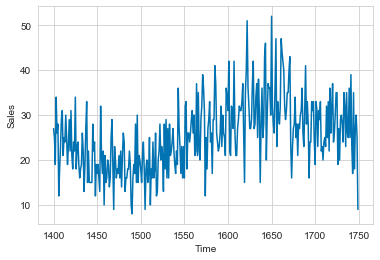

In [20]:
# set validation period
time_valid = time[1400:1750]
x_valid = series[1400:1750]

plot_series(time_valid, x_valid)

## Perturb Series

In [13]:
np.random.seed(28)
perturbed_series = np.append(series[:1400], series[1400:1750]+20+np.random.normal(0,2,350))

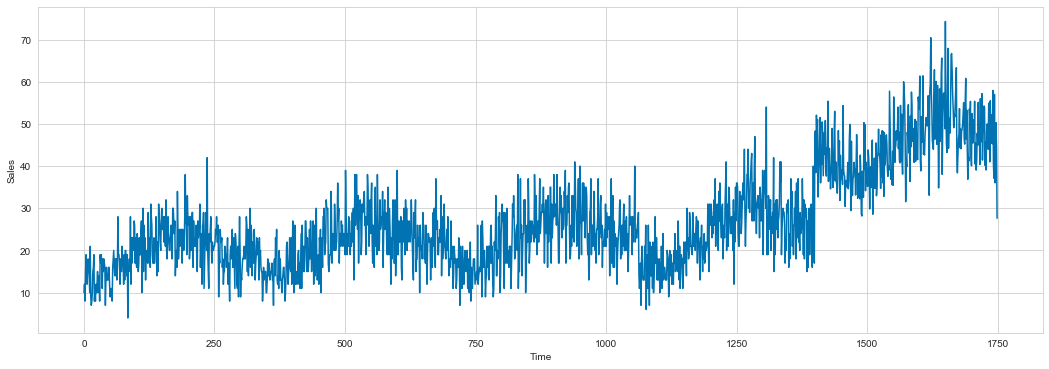

In [14]:
plt.figure(figsize=(18, 6))
plot_series(time, perturbed_series)


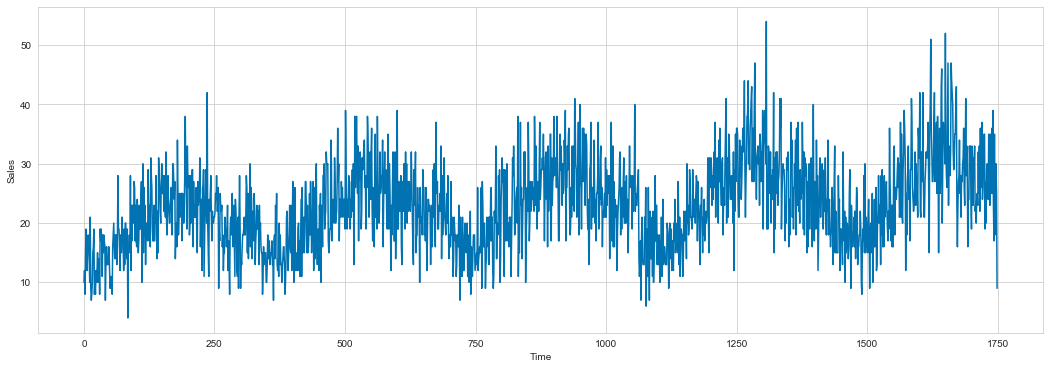

In [15]:
# regenerate plot to compare 

plt.figure(figsize=(18, 6))
plt.xlabel("Time")
plot_series(time, series)

In [151]:
true_causal_effect = perturbed_series[1400:1750] - x_valid

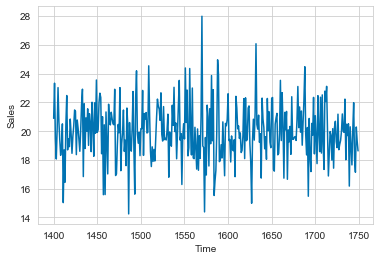

In [152]:
plot_series(time_valid, true_causal_effect)

In [142]:
ci_ts.cumsum()

array([  20.89266476,   44.23090486,   63.70234493,   81.76667508,
        101.88505193,  124.9142919 ,  145.58803279,  164.98329539,
        183.30601178,  202.27054928,  222.77756501,  237.80815703,
        256.5053173 ,  272.95437899,  293.42295065,  315.90175037,
        334.60108182,  354.06865196,  372.99121242,  393.83269348,
        413.64212083,  432.10236863,  451.73491956,  472.08853746,
        493.56264984,  514.95037512,  533.31931446,  554.09467537,
        574.30774938,  593.67859554,  612.27916982,  632.38514638,
        654.25336207,  677.17310634,  694.01535211,  715.91988497,
        734.71496609,  755.63785594,  775.62993764,  797.1846337 ,
        816.19840808,  837.41546981,  858.04393818,  876.62133065,
        898.63192274,  919.05444068,  937.308143  ,  959.27645714,
        979.13605079, 1002.69349483, 1022.60818264, 1042.70114295,
       1064.70294209, 1087.3450354 , 1109.68722799, 1128.11683832,
       1149.12426996, 1164.7048961 , 1185.14857417, 1200.73966

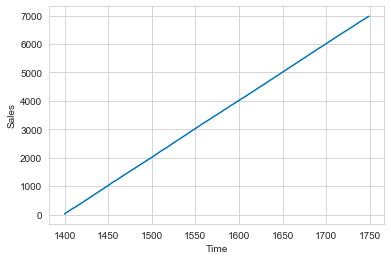

In [143]:
plot_series(time_valid, ci_ts.cumsum())

In [116]:
len(series[1400:1750])

350

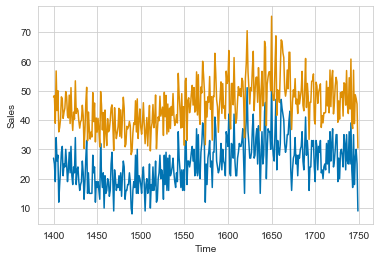

In [118]:
plot_series(time_valid, series[1400:1750])
plot_series(time_valid, series[1400:1750]+20+np.random.normal(0,2, 350))

# Preprocessing

In [38]:
split_time = 1400
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [24]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [25]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

# Modelling

# Moving Average Baseline

In [115]:
def moving_average_forecast(series, window_size):
     
    """Forecasts the mean of the last few values.
    If window_size=1, then this is equivalent to naive forecast"""
    
     # forecast is a list of numpy values
    forecast = []
    
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
        
    return np.array(forecast)

## Build Model

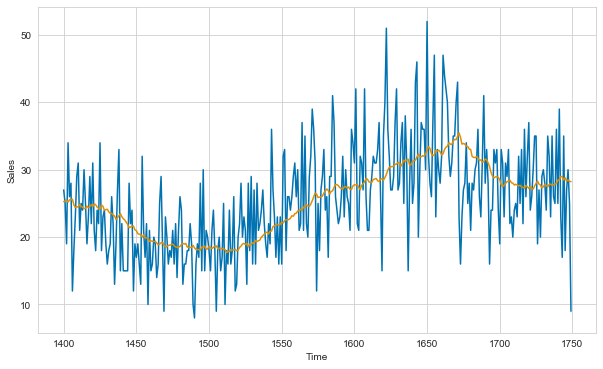

In [77]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [79]:
print(tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

5.094095238095238


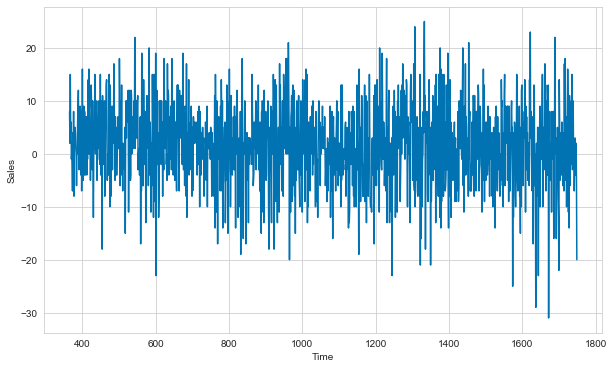

In [80]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

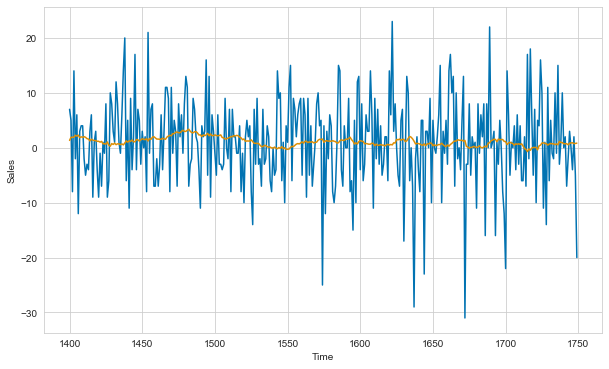

In [81]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

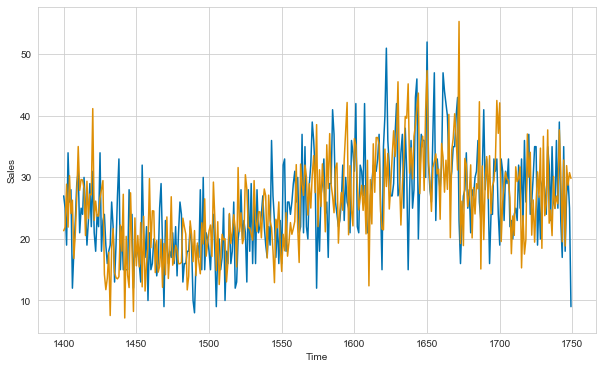

In [82]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [84]:
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

6.375028571428571


## Generate Forecast

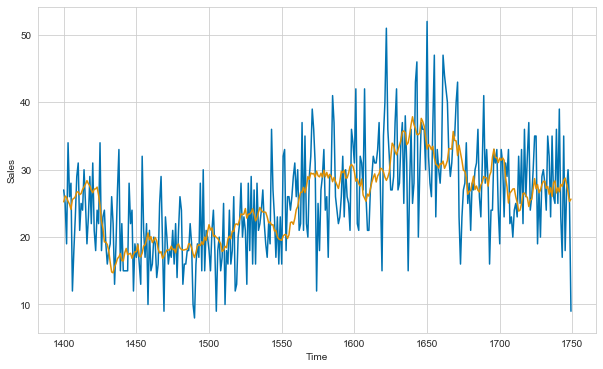

In [85]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

## Evaluation

In [156]:
print(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

41.99886857142857
5.022857142857142


# Neural Network Approach

## Build Model

In [28]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.int64, tf.int64)>
(1400,)
Epoch 1/100
6/6 [==============================] - 2s 363ms/step - loss: 35.3161 - mae: 35.9418
Epoch 2/100
6/6 [==============================] - 1s 116ms/step - loss: 33.9645 - mae: 34.6387
Epoch 3/100
6/6 [==============================] - 1s 112ms/step - loss: 31.9714 - mae: 32.6851
Epoch 4/100
6/6 [==============================] - 1s 120ms/step - loss: 29.8984 - mae: 30.6311
Epoch 5/100
6/6 [==============================] - 1s 124ms/step - loss: 27.9698 - mae: 28.7080
Epoch 6/100
6/6 [==============================] - 1s 115ms/step - loss: 26.1837 - mae: 26.9226
Epoch 7/100
6/6 [==============================] - 1s 115ms/step - loss: 24.4542 - mae: 25.1935
Epoch 8/100
6/6 [==============================] - 1s 113ms/step - loss: 22.7074 - mae: 23.4478
Epoch 9/100
6/6 [==============================] - 1s 115ms/step - loss: 20.8954 - mae: 21.6380
Epoch 10/100
6/6 [====================

Epoch 86/100
6/6 [==============================] - 1s 138ms/step - loss: 6.3297 - mae: 6.7782
Epoch 87/100
6/6 [==============================] - 1s 138ms/step - loss: 6.0208 - mae: 6.4687
Epoch 88/100
6/6 [==============================] - 1s 150ms/step - loss: 8.8313 - mae: 9.0913
Epoch 89/100
6/6 [==============================] - 1s 139ms/step - loss: 17.5788 - mae: 15.8985
Epoch 90/100
6/6 [==============================] - 1s 138ms/step - loss: 14.7614 - mae: 16.0692
Epoch 91/100
6/6 [==============================] - 1s 143ms/step - loss: 12.0711 - mae: 12.7305
Epoch 92/100
6/6 [==============================] - 1s 142ms/step - loss: 11.7186 - mae: 11.7378
Epoch 93/100
6/6 [==============================] - 1s 143ms/step - loss: 16.1033 - mae: 16.3194
Epoch 94/100
6/6 [==============================] - 1s 141ms/step - loss: 16.7254 - mae: 18.0883
Epoch 95/100
6/6 [==============================] - 1s 142ms/step - loss: 36.5249 - mae: 37.6245
Epoch 96/100
6/6 [==================

[1e-08, 0.0001, 0, 60]

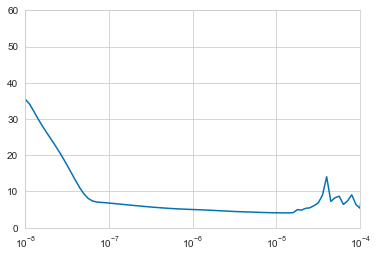

In [29]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])


In [33]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)


Epoch 1/500
14/14 [==============================] - 2s 174ms/step - loss: 17.9446 - mae: 18.7274
Epoch 2/500
14/14 [==============================] - 1s 63ms/step - loss: 7.5727 - mae: 8.1544
Epoch 3/500
14/14 [==============================] - 1s 64ms/step - loss: 5.4619 - mae: 5.9643
Epoch 4/500
14/14 [==============================] - 1s 73ms/step - loss: 4.4352 - mae: 4.9158
Epoch 5/500
14/14 [==============================] - 1s 67ms/step - loss: 4.2802 - mae: 4.7562
Epoch 6/500
14/14 [==============================] - 1s 68ms/step - loss: 4.2353 - mae: 4.7105
Epoch 7/500
14/14 [==============================] - 1s 62ms/step - loss: 4.2101 - mae: 4.6858
Epoch 8/500
14/14 [==============================] - 1s 66ms/step - loss: 4.1865 - mae: 4.6624
Epoch 9/500
14/14 [==============================] - 1s 63ms/step - loss: 4.1653 - mae: 4.6406
Epoch 10/500
14/14 [==============================] - 1s 63ms/step - loss: 4.1473 - mae: 4.6221
Epoch 11/500
14/14 [==========================

14/14 [==============================] - 1s 80ms/step - loss: 3.8943 - mae: 4.3636
Epoch 171/500
14/14 [==============================] - 1s 73ms/step - loss: 3.8940 - mae: 4.3632
Epoch 172/500
14/14 [==============================] - 1s 83ms/step - loss: 3.8936 - mae: 4.3629
Epoch 173/500
14/14 [==============================] - 1s 73ms/step - loss: 3.8934 - mae: 4.3627
Epoch 174/500
14/14 [==============================] - 1s 72ms/step - loss: 3.8931 - mae: 4.3624
Epoch 175/500
14/14 [==============================] - 1s 73ms/step - loss: 3.8929 - mae: 4.3621
Epoch 176/500
14/14 [==============================] - 1s 84ms/step - loss: 3.8926 - mae: 4.3618
Epoch 177/500
14/14 [==============================] - 1s 77ms/step - loss: 3.8923 - mae: 4.3616
Epoch 178/500
14/14 [==============================] - 1s 75ms/step - loss: 3.8921 - mae: 4.3613
Epoch 179/500
14/14 [==============================] - 1s 76ms/step - loss: 3.8918 - mae: 4.3610
Epoch 180/500
14/14 [=======================

14/14 [==============================] - 1s 67ms/step - loss: 3.8546 - mae: 4.3231
Epoch 339/500
14/14 [==============================] - 1s 64ms/step - loss: 3.8544 - mae: 4.3229
Epoch 340/500
14/14 [==============================] - 1s 65ms/step - loss: 3.8541 - mae: 4.3226
Epoch 341/500
14/14 [==============================] - 1s 63ms/step - loss: 3.8539 - mae: 4.3224
Epoch 342/500
14/14 [==============================] - 1s 62ms/step - loss: 3.8537 - mae: 4.3221
Epoch 343/500
14/14 [==============================] - 1s 63ms/step - loss: 3.8535 - mae: 4.3219
Epoch 344/500
14/14 [==============================] - 1s 62ms/step - loss: 3.8533 - mae: 4.3217
Epoch 345/500
14/14 [==============================] - 1s 62ms/step - loss: 3.8531 - mae: 4.3215
Epoch 346/500
14/14 [==============================] - 1s 64ms/step - loss: 3.8529 - mae: 4.3213
Epoch 347/500
14/14 [==============================] - 1s 64ms/step - loss: 3.8527 - mae: 4.3211
Epoch 348/500
14/14 [=======================

## Generate Forecast

In [42]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]


## Evaluation

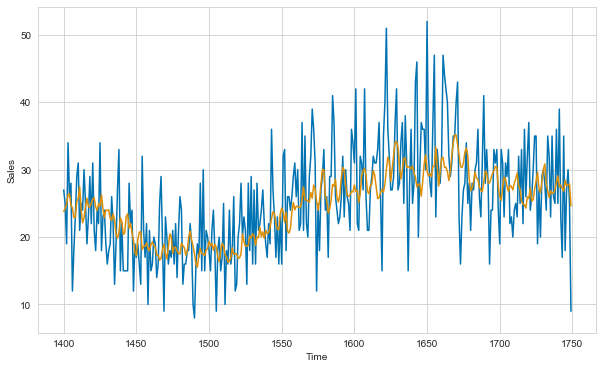

In [43]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

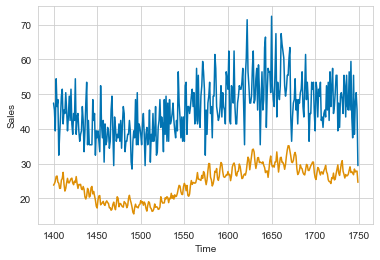

In [97]:
plot_series(time_valid, perturbed_series[1400:1750])
plot_series(time_valid, rnn_forecast)

In [154]:
# Forecasting Error
print(tf.keras.metrics.mean_absolute_error(x_valid , rnn_forecast).numpy())
print(tf.keras.metrics.mean_squared_error(x_valid, rnn_forecast).numpy())

4.9558606
39.945797


In [155]:
# Causal Inference Error

print(tf.keras.metrics.mean_absolute_error(perturbed_series[1400:1750] - x_valid, perturbed_series[1400:1750] - rnn_forecast).numpy())
print(tf.keras.metrics.mean_squared_error(perturbed_series[1400:1750] - x_valid, perturbed_series[1400:1750] - rnn_forecast).numpy())

4.955860568455288
39.945796954060945
